In [56]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras.datasets import mnist

In [57]:
import gdown

# gdown.download(id='18uC7WTuEXKJDDxbj-Jq6EjzpFrgE7IAd', output='dogs-vs-cats.zip')

In [58]:
# !unzip -qq dogs-vs-cats.zip
# !unzip -qq train.zip

In [59]:
import os, shutil, pathlib

original_dir = pathlib.Path('train') # train 폴더를 원본 데이터셋의 디렉토리로 설정
new_base_dir = pathlib.Path('cats_vs_dogs_small')

def make_subset(subset_name, start_index, end_index) :
  for category in('cat', 'dog') :
    dir = new_base_dir / subset_name / category # 각 카테고리의 새로운 디렉토리 경로 생성
    if dir.exists():
            shutil.rmtree(dir) # 이미 디렉토리가 존재하면 삭제
    os.makedirs(dir)
    fnames = [f'{category}.{i}.jpg' for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src = original_dir / fname, dst = dir / fname) # 원본 디렉토리에서 해당 파일을 복사하여 새 디렉토리에 붙여넣기

make_subset('train', start_index = 0, end_index = 1000)
make_subset('validation', start_index = 1000, end_index = 1500)
make_subset('test', start_index = 1500, end_index = 2500)

In [60]:
from tensorflow.python.util.traceback_utils import include_frame

conv_base = keras.applications.vgg16.VGG16(
    weights = 'imagenet', # 모델에 imagenet 데이터베이스에서 훈련된 가중치를 사용하겠다는 의미
    include_top = False,
    input_shape = (180, 180, 3)
  )

In [61]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [62]:
def get_features_and_labels(dataset) :
  all_features = []
  all_labels = []

  for images, labels in dataset :
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)

  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 20ms/step


In [63]:
train_features.shape

(2000, 5, 5, 512)

밀집 연결 분류기 정의하고 훈련하기

In [64]:
inputs = keras.Input(shape = (5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model = keras.Model(inputs, outputs)
model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'feature_extraction.keras',
        save_best_only = True,
        monitor = 'val_loss'
    )
]

history = model.fit(
    train_features, train_labels,
    epochs = 20,
    validation_data = (val_features, val_labels),
    callbacks = callbacks
)

Epoch 1/20
63/63 [==============================] - 1s 8ms/step - loss: 18.6037 - accuracy: 0.9240 - val_loss: 4.0348 - val_accuracy: 0.9690
Epoch 2/20
63/63 [==============================] - 0s 4ms/step - loss: 2.9950 - accuracy: 0.9775 - val_loss: 4.9470 - val_accuracy: 0.9700
Epoch 3/20
63/63 [==============================] - 0s 4ms/step - loss: 3.0222 - accuracy: 0.9750 - val_loss: 6.4487 - val_accuracy: 0.9670
Epoch 4/20
63/63 [==============================] - 0s 4ms/step - loss: 1.0707 - accuracy: 0.9910 - val_loss: 9.1589 - val_accuracy: 0.9540
Epoch 5/20
63/63 [==============================] - 0s 5ms/step - loss: 1.0654 - accuracy: 0.9930 - val_loss: 7.7447 - val_accuracy: 0.9660
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.7170 - accuracy: 0.9935 - val_loss: 3.9514 - val_accuracy: 0.9760
Epoch 7/20
63/63 [==============================] - 0s 4ms/step - loss: 0.2561 - accuracy: 0.9970 - val_loss: 5.9023 - val_accuracy: 0.9680
Epoch 8/20
63/63 [=

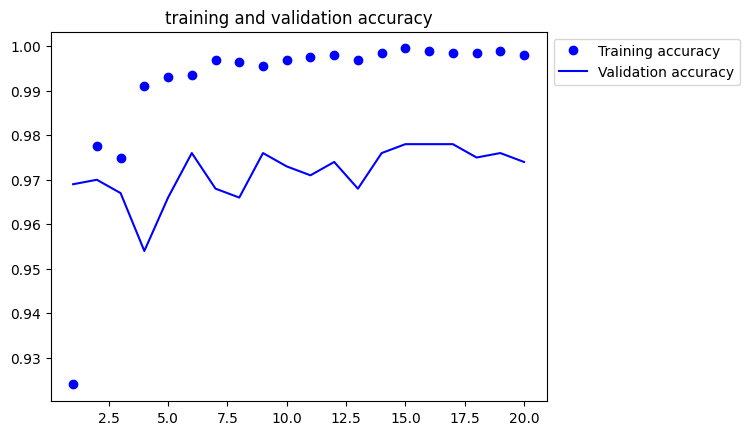

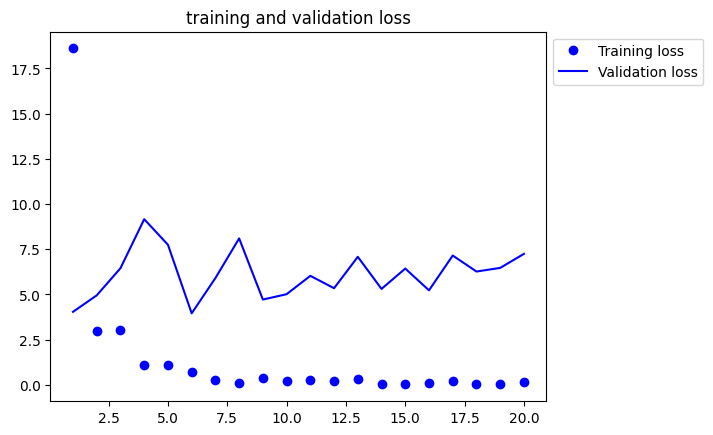

In [65]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('training and validation accuracy')
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('training and validation loss')
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')

plt.show()

In [66]:
test_model = keras.models.load_model('feature_extraction.keras')
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f'테스트정확도 : {test_acc: .3f}')

63/63 [==============================] - 0s 3ms/step - loss: 7.4866 - accuracy: 0.9690
테스트정확도 :  0.969


데이터 증식을 사용한 특성 추출

vgg16 합성곱 기반 층을 만들고 동결하기

In [67]:
conv_base = keras.applications.vgg16.VGG16(
    weights = 'imagenet',
    include_top = False
)
conv_base.trainable = False

In [68]:
conv_base.trainable = True
print('합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수 :',
      len(conv_base.trainable_weights))
conv_base.trainable = False
print('합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수 : ',
      len(conv_base.trainable_weights))

합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수 : 26
합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수 :  0


In [69]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [70]:
inputs = keras.Input(shape = (180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model = keras.Model(inputs, outputs)
model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'feature_extraction_with_data_augmentation.keras',
        save_best_only = True,
        monitor = 'val_loss'
    )
]

history = model.fit(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/50
63/63 [==============================] - 11s 155ms/step - loss: 21.6389 - accuracy: 0.8965 - val_loss: 5.2505 - val_accuracy: 0.9580
Epoch 2/50
63/63 [==============================] - 10s 152ms/step - loss: 9.5436 - accuracy: 0.9320 - val_loss: 13.3383 - val_accuracy: 0.9490
Epoch 3/50
63/63 [==============================] - 10s 153ms/step - loss: 6.2087 - accuracy: 0.9510 - val_loss: 8.2344 - val_accuracy: 0.9530
Epoch 4/50
63/63 [==============================] - 9s 148ms/step - loss: 5.5139 - accuracy: 0.9580 - val_loss: 7.0723 - val_accuracy: 0.9600
Epoch 5/50
63/63 [==============================] - 10s 150ms/step - loss: 3.4205 - accuracy: 0.9685 - val_loss: 4.1921 - val_accuracy: 0.9720
Epoch 6/50
63/63 [==============================] - 10s 150ms/step - loss: 3.5956 - accuracy: 0.9680 - val_loss: 4.0626 - val_accuracy: 0.9760
Epoch 7/50
63/63 [==============================] - 10s 150ms/step - loss: 3.4272 - accuracy: 0.9640 - val_loss: 3.8080 - val_accuracy: 0.976

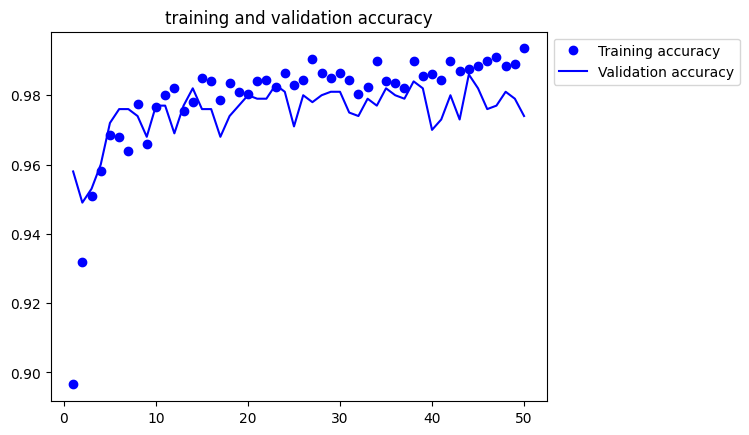

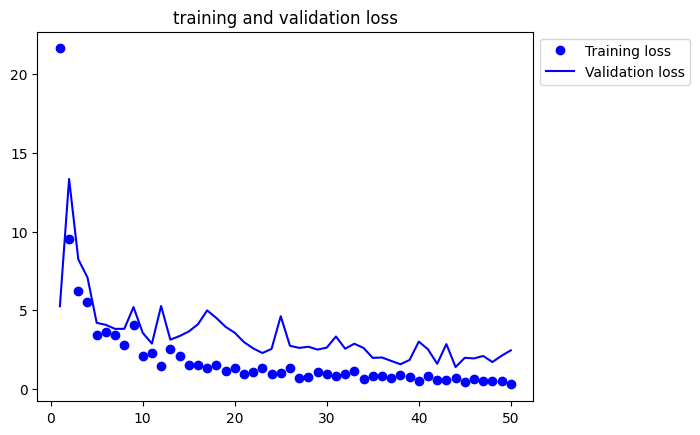

In [71]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('training and validation accuracy')
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('training and validation loss')
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')

plt.show()

In [72]:
test_model = keras.models.load_model('feature_extraction_with_data_augmentation.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'테스트정확도 : {test_acc: .3f}')

63/63 [==============================] - 6s 95ms/step - loss: 2.1445 - accuracy: 0.9750
테스트정확도 :  0.975


사전 훈련된 모델 미세 조정하기

In [74]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [75]:
conv_base.trainable = True

for layer in conv_base.layers[: -4] :
  layer.trainable = False

In [76]:
model.compile(loss = 'binary_crossentropy',
              optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5),
              metrics = ['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'fine_tuning.keras',
        save_best_only = True,
        monitor = 'val_loss'
    )
]

history = model.fit(
    train_dataset,
    epochs = 30,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/30
63/63 [==============================] - 14s 165ms/step - loss: 0.3163 - accuracy: 0.9885 - val_loss: 2.8826 - val_accuracy: 0.9750
Epoch 2/30
63/63 [==============================] - 10s 160ms/step - loss: 0.4376 - accuracy: 0.9880 - val_loss: 1.9797 - val_accuracy: 0.9820
Epoch 3/30
63/63 [==============================] - 10s 155ms/step - loss: 0.1272 - accuracy: 0.9930 - val_loss: 2.0780 - val_accuracy: 0.9820
Epoch 4/30
63/63 [==============================] - 10s 159ms/step - loss: 0.3050 - accuracy: 0.9940 - val_loss: 1.8921 - val_accuracy: 0.9820
Epoch 5/30
63/63 [==============================] - 10s 154ms/step - loss: 0.2239 - accuracy: 0.9935 - val_loss: 2.0978 - val_accuracy: 0.9800
Epoch 6/30
63/63 [==============================] - 10s 159ms/step - loss: 0.2512 - accuracy: 0.9920 - val_loss: 1.6632 - val_accuracy: 0.9820
Epoch 7/30
63/63 [==============================] - 10s 157ms/step - loss: 0.2439 - accuracy: 0.9935 - val_loss: 2.1176 - val_accuracy: 0.9820

In [78]:
test_model = keras.models.load_model('fine_tuning.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'테스트정확도 : {test_acc: .3f}')

63/63 [==============================] - 6s 86ms/step - loss: 1.6682 - accuracy: 0.9740
테스트정확도 :  0.974


 ### 이미지 분할 예제

In [103]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar  -xf images.tar.gz
!tar  -xf annotations.tar.gz

--2023-07-11 02:23:23--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-07-11 02:23:24--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-07-11 02:23:25--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [104]:
!ls

annotations					 images
annotations.tar.gz				 images.tar.gz
cats_vs_dogs_small				 sample_data
dogs-vs-cats.zip				 sampleSubmission.csv
feature_extraction.keras			 test1.zip
feature_extraction_with_data_augmentation.keras  train
fine_tuning.keras				 train.zip


In [105]:
!ls annotations

list.txt  README  test.txt  trainval.txt  trimaps  xmls


In [106]:
import os

input_dir = 'images/'
target_dir = 'annotations/trimaps/'

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith('.jpg')]
)

target_paths = sorted(
    [os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith('.png') and not fname.startswith('.')]
)

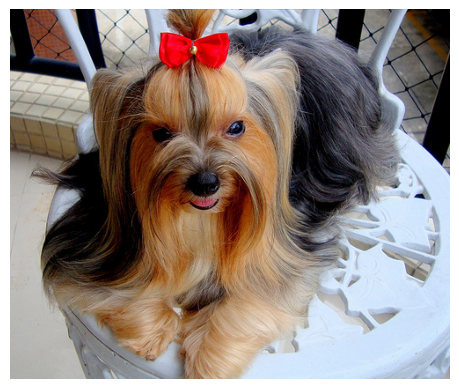

In [115]:
from tensorflow.keras.utils import load_img, img_to_array

plt.axis('off')
plt.imshow(load_img(input_img_paths[9]))

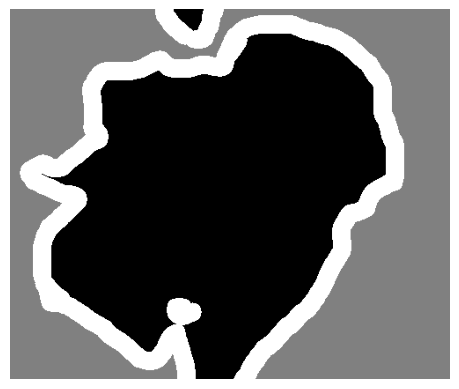

In [114]:
def display_target(target_array) :
  # 원래 레이블은 1 2 3 이며 여기서 1을 빼서 0~2 범위로 변경후 127을 곱하여 레이블 값 0 검은색
  # 127 회색 254 흰색으로 변경
  normalized_array = (target_array.astype('uint8') - 1) * 127
  plt.axis('off')
  plt.imshow(normalized_array[:, :, 0], cmap = 'gray')

img = img_to_array(load_img(target_paths[9], color_mode = 'grayscale'))
display_target(img)

In [113]:
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path) :
  return img_to_array(load_img(path, target_size = img_size))

def path_to_target(path) :
  img = img_to_array(
      load_img(path, target_size = img_size, color_mode = 'grayscale')
  )
  img = img.astype('uint8')
  return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype = 'float32')
targets = np.zeros((num_imgs,) + img_size + (1,), dtype = 'uint8')

for i in range(num_imgs) :
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[: -num_val_samples]
train_targets = targets[: -num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [118]:
def get_model(img_size, num_classes) :
  inputs = keras.Input(shape = img_size + (3,))
  x = layers.Rescaling(1./255)(inputs)

  x = layers.Conv2D(64, 3, strides = 2, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(128, 3, strides = 2, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(256, 3, strides = 2, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2D(256, 3, activation = 'relu', padding = 'same')(x)

  x = layers.Conv2DTranspose(256, 3, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2DTranspose(256, 3, activation = 'relu', padding = 'same', strides = 2)(x)
  x = layers.Conv2DTranspose(128, 3, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2DTranspose(128, 3, activation = 'relu', padding = 'same', strides = 2)(x)
  x = layers.Conv2DTranspose(64, 3, activation = 'relu', padding = 'same')(x)
  x = layers.Conv2DTranspose(64, 3, activation = 'relu', padding = 'same', strides = 2)(x)

  outputs = layers.Conv2D(num_classes, 3, activation = 'softmax',
                          padding = 'same')(x)
  model = keras.Model(inputs, outputs)

  return model

model = get_model(img_size = img_size, num_classes = 3)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 conv2d_18 (Conv2D)          (None, 100, 100, 64)      36928     
                                                                 
 conv2d_19 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 conv2d_20 (Conv2D)          (None, 50, 50, 128)       147584    
                                                                 
 conv2d_21 (Conv2D)          (None, 25, 25, 256)       2951